In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score,classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [ ]:
df = pd.read_csv("Merged_Cleaned_1Based.csv")
X = df[['VPN_Status', 'flowBytesPerSecond', 'min_flowiat', 'min_fiat', 'std_flowiat', 
        'min_biat', 'duration', 'max_flowiat', 'total_fiat', 'mean_fiat', 
        'flowPktsPerSecond', 'mean_flowiat', 'total_biat']]
y = df["label"]


def feature_engineering(df):
    # ========== Ratio-based features ==========
    df['bytes_per_packet'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + 1e-6)
    df['pkts_per_duration'] = df['flowPktsPerSecond'] / (df['duration'] + 1e-6)
    df['bytes_per_duration'] = df['flowBytesPerSecond'] / (df['duration'] + 1e-6)
    df['fiat_biat_ratio'] = (df['total_fiat'] + 1e-6) / (df['total_biat'] + 1e-6)

    # ========== Log-transforms (to handle skewness) ==========
    df['log_flowBytesPerSecond'] = np.log1p(df['flowBytesPerSecond'])
    df['log_duration'] = np.log1p(df['duration'])
    df['log_flowPktsPerSecond'] = np.log1p(df['flowPktsPerSecond'])
    df['log_total_fiat'] = np.log1p(df['total_fiat'])
    df['log_total_biat'] = np.log1p(df['total_biat'])

    # ========== Interaction features ==========
    df['fiat_interaction'] = df['min_fiat'] * df['mean_fiat']
    df['biat_interaction'] = df['min_biat'] * df['total_biat']
    df['iat_ratio'] = df['mean_flowiat'] / (df['std_flowiat'] + 1e-6)
    df['iat_mixed'] = df['min_flowiat'] * df['max_flowiat']
    df['iat_range'] = df['max_flowiat'] - df['min_flowiat']

    # ========== Statistical transformations ==========
    df['fiat_to_duration'] = df['total_fiat'] / (df['duration'] + 1e-6)
    df['biat_to_duration'] = df['total_biat'] / (df['duration'] + 1e-6)
    df['flowiat_cv'] = df['std_flowiat'] / (df['mean_flowiat'] + 1e-6)  

    # ========== Normalized / standardized ratios ==========
    df['normalized_bytes'] = df['flowBytesPerSecond'] / (df['flowBytesPerSecond'].max() + 1e-6)
    df['normalized_packets'] = df['flowPktsPerSecond'] / (df['flowPktsPerSecond'].max() + 1e-6)

    # ========== Aggregated combinations ==========
    df['activity_score'] = (df['flowPktsPerSecond'] + df['flowBytesPerSecond']) / (df['duration'] + 1e-6)
    df['iat_activity'] = df['mean_flowiat'] * df['flowPktsPerSecond']

    return df


X = feature_engineering(X)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)
y_test=y_test-1
y_train=y_train-1

C:\Users\msanj\AppData\Local\Temp\ipykernel_17084\3193548653.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bytes_per_packet'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + 1e-6)
C:\Users\msanj\AppData\Local\Temp\ipykernel_17084\3193548653.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pkts_per_duration'] = df['flowPktsPerSecond'] / (df['duration'] + 1e-6)
C:\Users\msanj\AppData\Local\Temp\ipykernel_17084\3193548653.py:12: SettingWithCopyWarning: 
A value is trying to be set on

In [3]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    scale_pos_weight=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

In [4]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_features='log2',
    class_weight="balanced",
    random_state=42
)

In [5]:
lgbm_model= LGBMClassifier(
    n_estimators=417, 
    learning_rate=0.05400296691312082,
    max_depth=16,                
    num_leaves=59,                
    subsample=0.8103841048255219,   
    colsample_bytree=0.9433269199679768,
    min_child_samples=91,           
    reg_alpha=0.022907420080679457,   
    reg_lambda=1.4774925707606652,   
    class_weight='balanced',       
    random_state=42,
    n_jobs=-1
)

In [6]:
meta_learner=LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42)

In [7]:
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lgbm',lgbm_model)
    ],
    final_estimator=meta_learner,
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                               colsample_bytree=0.9433269199679768,
                                               learning_rate=0.05400296691312082,
                                               max_depth=16,
                                               min_child_samples=91,
                                               n_estimators=417, n_jobs=-1,
                                               num_leaves=59, random_state=42,
                                               reg_alpha=0.022907420080679457,
                                               reg_lambda=1.4774925707606652,
                                               subsample=0.8103841048255219))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1, stack_method='predict_proba')

In [ ]:
y_pred = stacking_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("Stacking Ensemble Accuracy:", acc)
print("Classification report:",classification_report(y_test,y_pred))
print("Stacking Ensemble Balanced Accuracy:", bal_acc)

Stacking Ensemble Accuracy: 0.9752810994110298
Classification report:               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2000
           1       0.94      0.96      0.95       494
           2       0.98      0.96      0.97       664
           3       0.93      0.96      0.95       244
           4       1.00      0.99      1.00       786
           5       0.94      0.96      0.95       232
           6       1.00      0.99      1.00      1288
           7       0.98      0.97      0.98      1941
           8       0.90      0.94      0.92       537
           9       0.95      0.94      0.95       904
          10       0.92      0.99      0.95       285
          11       0.99      0.99      0.99       498
          12       0.98      1.00      0.99       223
          13       1.00      0.98      0.99      1110

    accuracy                           0.98     11206
   macro avg       0.96      0.97      0.97     11206
weighted a

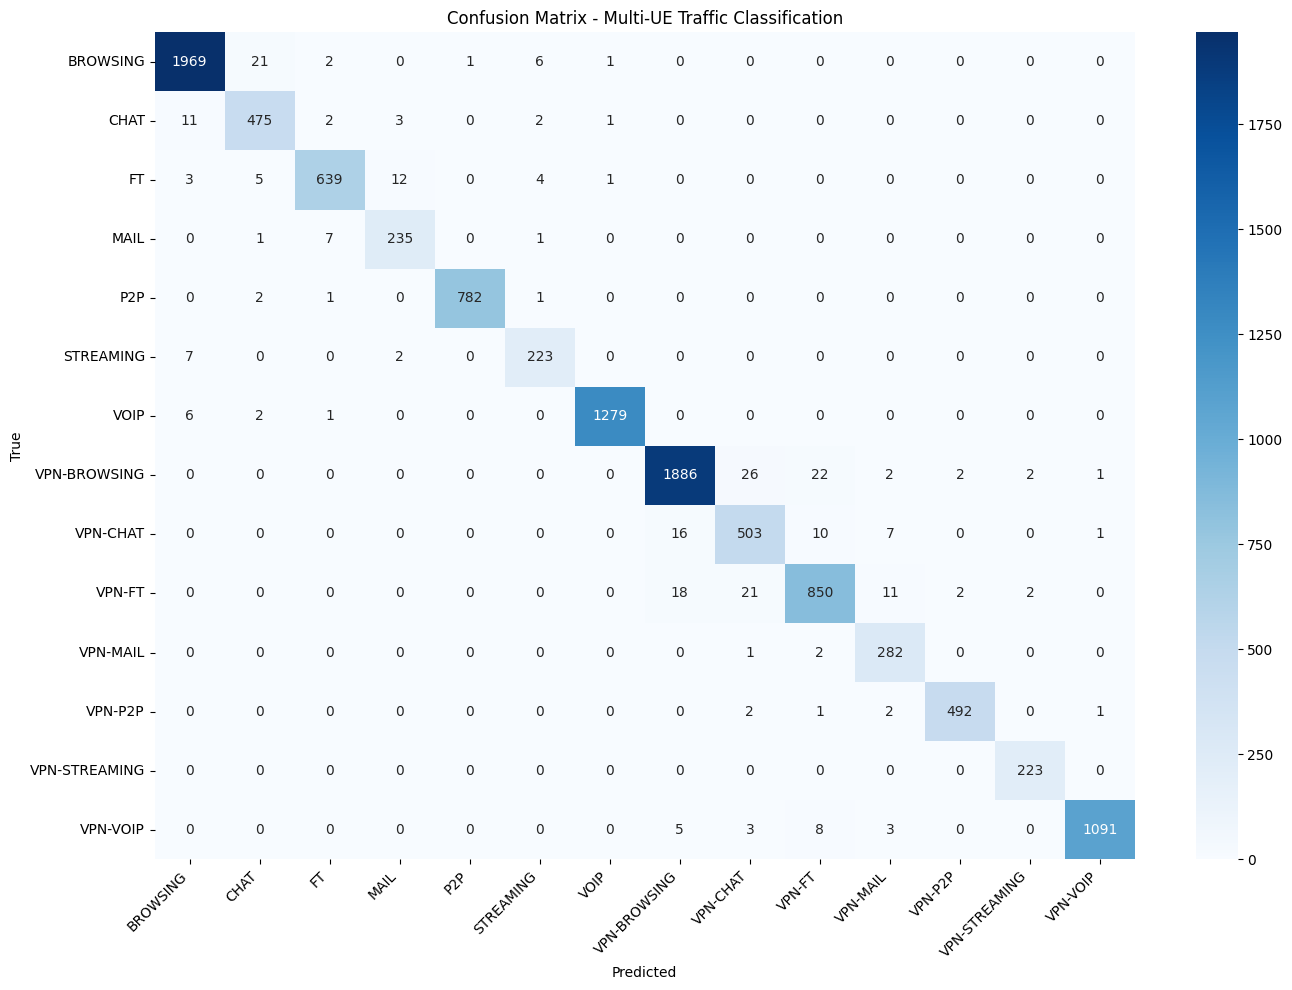

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class_mapping = {
    'BROWSING': 0, 'CHAT': 1, 'FT': 2, 'MAIL': 3, 'P2P': 4, 'STREAMING': 5,
    'VOIP': 6, 'VPN-BROWSING': 7, 'VPN-CHAT': 8, 'VPN-FT': 9, 'VPN-MAIL': 10,
    'VPN-P2P': 11, 'VPN-STREAMING': 12, 'VPN-VOIP': 13
}


idx_to_label = {v: k for k, v in class_mapping.items()}


cm = confusion_matrix(y_test, y_pred, labels=range(len(class_mapping)))

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[idx_to_label[i] for i in range(len(class_mapping))],
            yticklabels=[idx_to_label[i] for i in range(len(class_mapping))])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Multi-UE Traffic Classification")
plt.xticks(rotation=45, ha="right")   
plt.tight_layout()
plt.show()



In [10]:
import joblib
joblib.dump(stacking_model,'model.joblib')

['model.joblib']